Aclaración importante: Las conclusiones expuestas en este documento no son las mismas que se han escrito en la memoria, estas de aquí son una especie de "apuntes rápidos" sobre temas de los que se han hablado en mayor profundidad y corrección en la memoria.

In [1]:
import numpy as np
import cv2
import copy
import matplotlib.pyplot as plt
import pandas as pd
import lector_imagenes as li
import extrac1 as ex1
import extrac2 as ex2
import vectoresAFichero as vf

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Paso 1: Lectura de los datos
Para realizar el tratamiento de las imágenes, es necesario leerlas desde los directorios correspondientes. Se ha implementado para este fin el script "lector_imagenes.py", que se encarga de, dada una dirección, un valor sobre blanco o negro (según como queramos leer las imágenes) y un tamaño (todas las imágenes deberán tener el mismo tamaño, de lo contrario no seremos capaces de entrenar ningún modelo) extraer la matriz de dicha imagen y guardarla en un array.

Por otro lado, la función lee de todas las carpetas que encuentre dentro de la dirección indicada. Se espera encontrar dos carpetas (train y test) con dos subcarpetas a su vez (cat y dog). Obtendrá por tanto la lectura tanto de los datos de train como de test. Por último, mencionar que también calcula el vector de salida Y, donde indica a qué clase pertenece cada ejemplo. Se ha decidido de forma arbitraria que la clase gato sea 0 y perro 1.

In [2]:
#PASO 1: LECTURA DE LAS IMÁGENES

X_train,y_train,X_test,y_test = li.crea_dataset(path='cat_dog_100',BN=0) #Ver valores por defecto de la función (script lector_imagenes.py)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(200, 380, 380)
(200, 1)
(40, 380, 380)
(40, 1)


# Paso 2: Calcular vectores propios
Una vez tenemos las imágenes almacenadas como matrices dentro de nuestra estructura, debemos calcular sus vectores propios para poder operar con ellas. 
En este caso, tenemos dos scripts distintos, "extrac1.py" y "extrac2.py", correspondientes a cada una de las posibles implementaciones propuestas en la práctica. Estas dos, a su vez, cuentan con diversas opciones de implementación atendiendo a las posibles modificaciones disponibles.

Extrac1:
- Versión estándar, con el calculo de binarios.
- Versión estándar, con tratamiento a color de las imágenes.
- Versión uniforme, con el tratamiento de aquellos binarios no uniformes.

Extrac2:
- Versión estándar, con ruleta de gradientes de nueve bins.
- Versión estándar, con tratamiento a color de las imágenes.
- Versión normalizada, usando los vecinos.

Aparte de estos dos módelos de extracción, podemos aplicar PCA a los distintos vectores característicos.

Nota: El proceso de cálculo de vectores propios toma un tiempo.

In [7]:
#NO ES NECESARIO EJECUTAR ESTA CELDA (cálculo de vectores, se he hecho previamente y se ha guardado en un fichero)
#Según el método a utilizar y el tamaño de los conjuntos, esta celda puede ser considerablemente lenta

vec_train = []
vec_test = []

for i in range(len(X_train)):
    vec_train.append(ex1.crear_vector_caracteristicas_BW_Uniforme(X_train[i],16))
vec_train = np.asarray(vec_train)
print('Terminada lectura Train')

for i in range(len(X_test)):
    vec_test.append(ex1.crear_vector_caracteristicas_BW_Uniforme(X_test[i],16))
vec_test = np.asarray(vec_test)
print('Terminada lectura Test')

#Trato los valores nan por si acaso
vec_train[np.isnan(vec_train)] = 0
vec_test[np.isnan(vec_test)] = 0

Terminada lectura Test


Ya que el cálculo de vectores propios lleva un tiempo, hemos decicido leerlos una única vez y guardar los vectores calculados en ficheros. Para este fin se implementa el script "vectoresAFichero.py".

In [5]:
#Escribo en un ficheros los vectores leídos, esto, con el fin de ahorrar tiempo en futuras ejecuciones
#Hemos escrito en los ficheros solo los datos leidos de la carpeta de 100.
#NO EJECUTAR ESTA CELDA
vf.escribir('extrac1','color',vec_train,vec_test)

Una vez guardados los vectores en los ficheros, los iremos leyendo para entrenar los modelos y obtener los distintos resultados.

In [4]:
#Descoméntese el código según se quieran leer uno u otros datos.

'''
Versión estándar del primer modelo de extracción
'''
#vec_train = np.loadtxt('EX1_STD_100_vec_train.txt')
#vec_test = np.loadtxt('EX1_STD_100_vec_test.txt')


'''
Versión uniforme del primer modelo de extracción
'''
vec_train = np.loadtxt('EX1_UNIFORM_100_vec_train.txt') 
vec_test = np.loadtxt('EX1_UNIFORM_100_vec_test.txt')

'''
Versión estándar del segundo modelo de extracción
'''
#vec_train = np.loadtxt('EX2_STD_100_vec_train.txt')
#vec_test = np.loadtxt('EX2_STD_100_vec_test.txt')

'''
Versión normalizada del segundo modelo de extracción
'''
#vec_train = np.loadtxt('EX2_NORMALIZADA_100_vec_train.txt')
#vec_test = np.loadtxt('EX2_NORMALIZADA_100_vec_test.txt')


'\nVersión normalizada del segundo modelo de extracción\n'

Como hemos mencionado antes, podemos aplicar, si así lo deseamos, una transformación de PCA a los vectores.

In [103]:
#Aplico PCA a los vectores si así se desea
vec_train,vec_test = ex1.transforma_PCA(vec_train,vec_test,15)

# Paso 3: Entrenamiento de modelos y predicción
Finalmente, una vez obtenidos los vectores característicos de todas las imágenes, probaremos a entrenar diversos modelos disponibles en la librería scikit para, dado un nuevo vector de características, tratar de predecir a qué clase pertenece, si perros o gatos.

## Modelo 1: Regresión Lineal
Una primera aproximación para la predicción puede ser usando una regresión lineal. Lo que hacemos es predecir la "tendencia" de los vectores. En ese caso, pueden tender hacia 1 o hacia 0. En realidad, una regresión lineal no es un modelo correcto para este tipo de problema, que salta a la vista que se trata de uno de clasificación. No obstante, se empieza por aquí para comprobar el efecto de un modelo "simple y rápido" sobre nuestras variables. 

In [6]:
##REGRESIÓN LINEAL DE N VARIABLES

#Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente a la regresión lineal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'fit_intercept': [True,False],
    'copy_X': [True,False],
    'n_jobs': [-1, 1, 10],
    'positive': [True, False],
}
# Genera el objeto ShuffleSplit para generar un único particionado fijo, con 20% de datos de validación y 
# random_state = 0
ss = ShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
# Haz la llamada a la función GridSearchCV con un clasificador SVC y el diccionario de parámetros definido
# Para acelerar algo el entrenamiento, emplea también el parámetro n_jobs=-1, que hará que se aproveche mejor el
# procesador de tu equipo.
regr = LinearRegression()
clasificadores = GridSearchCV(regr,parameter_space,cv=ss)
# Entrena el modelo interno de GridSearchCV, y después obten los mejores valores de C y gamma en C_best y gamma_best
clasificadores = clasificadores.fit(vec_train,y_train)
accTrainBest = clasificadores.best_estimator_
# Calculo los resultados sobre el conjunto test
y_true, y_pred = y_test , accTrainBest.predict(vec_test)
print('Los resultados sobre el conjunto de test (calculados con el coeficiente de determinación) son:')
print(r2_score(y_true, y_pred))
aciertos = 0
fallados = []
for i in range(len(X_test)):
    if np.round(y_pred[i]) == y_test[i][0]:
        aciertos += 1
    else:
        fallados.append(i)

print('Usando regresión lineal se ha obtenido un accuracy del {}% '.format((aciertos/len(X_test))*100))
print('Las imágenes falladas en la predicción son:{}'.format(fallados))


Los resultados sobre el conjunto de test (calculados con el coeficiente de determinación) son:
0.3901249867647356
Usando regresión lineal se ha obtenido un accuracy del 85.0% 
Las imágenes falladas en la predicción son:[1, 5, 8, 10, 11, 16]


##### Resultados obtenidos con regresión lineal:
Extrac1:
- Versión estándar ~ 85% de accuracy.
- Versión uniforme ~ 85% de accuracy.
- Versión color 1 ~ 80% de accuracy.
- Versión PCA ~ 75% de accuracy (uniforme).

Extrac2:
- Versión estándar ~ 82.5% de accuracy.
- Versión a color ~ 80% de accuracy.
- Versión regularizada ~ 82.5% de accuracy.

## Modelo 2: Regresión Logística
En segundo lugar, usaremos el modelo que, al menos en apariencia, es el más adecuado para nuestro problema, la regresión logística o clasificación. En nuetro caso, tenemos dos clases distintas, 0 y 1 (gatos y perros).

Results on the test set:
              precision    recall  f1-score   support

         0.0       1.00      0.70      0.82        20
         1.0       0.77      1.00      0.87        20

    accuracy                           0.85        40
   macro avg       0.88      0.85      0.85        40
weighted avg       0.88      0.85      0.85        40

Las imágenes falladas en la predicción son: [1, 5, 8, 10, 11, 14]


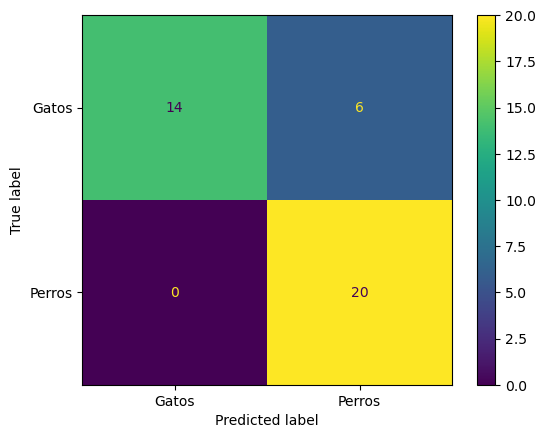

In [7]:
# Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente a la regresión logística
from sklearn.linear_model import LogisticRegression
# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'C': [1/0.1e-100,1,1/100],
    'solver' : ['newton-cg', 'lbfgs', 'sag']
}
# Genera el objeto ShuffleSplit para generar un único particionado fijo, con 20% de datos de validación y 
# random_state = 0
ss = ShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
# Haz la llamada a la función GridSearchCV con un clasificador SVC y el diccionario de parámetros definido
# Para acelerar algo el entrenamiento, emplea también el parámetro n_jobs=-1, que hará que se aproveche mejor el
# procesador de tu equipo.
LogReg = LogisticRegression(penalty='l2',max_iter=400)
clasificadores = GridSearchCV(LogReg,parameter_space,cv=ss,n_jobs=-1)
# Entrena el modelo interno de GridSearchCV, y después obten los mejores valores de C y gamma en C_best y gamma_best
clasificadores = clasificadores.fit(vec_train,y_train.ravel())
accTrainBest = clasificadores.best_estimator_
# Calculo los resultados sobre el conjunto test
y_true, y_pred = y_test , accTrainBest.predict(vec_test)
print('Results on the test set:')
print(classification_report(y_true, y_pred))
#Miro cuales son las imágenes falladas por la predicción
fallados = []
for i in range(len(X_test)):
    if np.round(y_pred[i]) != y_test[i][0]:
        fallados.append(i)

print('Las imágenes falladas en la predicción son: {}'.format(fallados))
#Muestro la matriz de confusión
class_names = ['Gatos', 'Perros']
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()

##### Resultados obtenidos con regresión logística:
Extrac1:
- Versión estándar ~ 82.5% de accuracy.
- Versión uniforme ~ 85% de accuracy.
- Versión color 1 ~ 80% de accuracy.
- Versión PCA ~ 70% de accuracy (uniforme).

Extrac2:
- Versión estándar ~ 82.5% de accuracy.
- Versión a color ~ 80% de accuracy,
- Versión regularizada ~ 82.5% de accuracy.

## Modelo 3: Naive Bayes
Optaremos ahora por un modelo distinto, uno probabilista.

Precisión en test: 0.8

Las imágenes falladas en la predicción son: [1, 6, 8, 10, 11, 18, 21, 26]


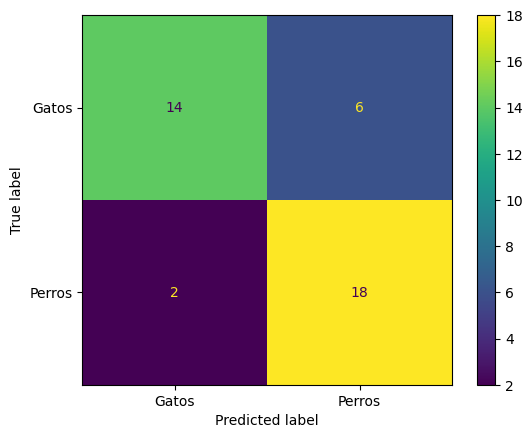

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

nb = GaussianNB()

# Entrenamos el clasificador NB
nb = nb.fit(vec_train,y_train.ravel())
# Obtenemos las salidas para las instancias de train utilizando predict
salTrain = nb.predict(vec_train)
# Obtenemos la precisión en train mediante metrics.accuracy_score (guardar en accTrain)
accTrain = metrics.accuracy_score(salTrain,y_train)
# Obtenemos las salidas para test mediante predict
salTest = nb.predict(vec_test)
# Obtenemos la precisión en test mediante metrics.accuracy_score (guardar en accTest)
accTest = metrics.accuracy_score(salTest,y_test)

# Imprimimos los resultados obtenidos
print("Precisión en test: {}\n".format(accTest))

y_true, y_pred = y_test , salTest
class_names = ['Gatos', 'Perros']
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
#Miro cuales son las imágenes falladas por la predicción
fallados = []
for i in range(len(X_test)):
    if np.round(y_pred[i]) != y_test[i][0]:
        fallados.append(i)

print('Las imágenes falladas en la predicción son: {}'.format(fallados))

##### Resultados obtenidos con Naive Bayes:
Extrac1:
- Versión uniforme ~ 80% de accuracy.

Extrac2:
- Versión regularizada ~ 75% de accuracy.


## Modelo 4: Red Neuronal
¿Y si probamos a usar perceptrones para predecir la salida de nuestro algoritmo? Esta es la idea de la red neuronal, que une varios de estos para obtener una respuesta a un problema complejo. Veamos cómo.

El mejor clasificador tiene los parámetros: MLPClassifier(activation='identity', alpha=0.05, hidden_layer_sizes=(2, 20, 2),
              learning_rate='adaptive', max_iter=1000, solver='lbfgs')
El porcentaje de acierto es de un 87.5%


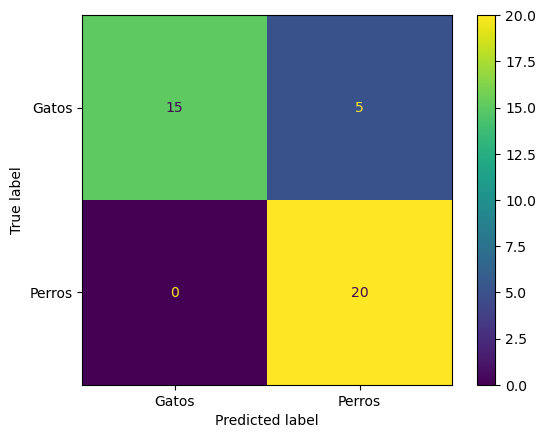

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'hidden_layer_sizes': [(2, 20, 2), (5, 15, 2)],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.05, 0.1, 0.15],
    'learning_rate': ['constant','adaptive'],
}

# Genera el objeto ShuffleSplit para generar un único particionado fijo, con 20% de datos de validación y 
# random_state = 0
ss = ShuffleSplit(n_splits=1,test_size=0.2,random_state=0)

# Haz la llamada a la función GridSearchCV con un clasificador SVC y el diccionario de parámetros definido
# Para acelerar algo el entrenamiento, emplea también el parámetro n_jobs=-1, que hará que se aproveche mejor el
# procesador de tu equipo.
mlp = MLPClassifier(activation='identity', max_iter = 1000)
clasificadores = GridSearchCV(mlp,parameter_space,cv=ss,n_jobs=-1)

# Entrena el modelo interno de GridSearchCV, y después obten los mejores valores de C y gamma en C_best y gamma_best
clasificadores = clasificadores.fit(vec_train,y_train.ravel())
mejorClasificador = clasificadores.best_estimator_
print('El mejor clasificador tiene los parámetros: {}'.format(mejorClasificador))

y_true, y_pred = y_test , mejorClasificador.predict(vec_test)
print('El porcentaje de acierto es de un {}%'.format(metrics.accuracy_score(y_true, y_pred)*100))

class_names = ['Gatos', 'Perros']
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()

##### Resultados obtenidos con Red neuronal:
Extrac1:
- Versión uniforme ~ 87.5% de accuracy.

Extrac2:
- Versión regularizada ~ 87.5% de accuracy.

## Modelo 5: SVMs
Seguimos con otro modelo de clasificación. En este caso, los SVMs (support vector machines). Este clasificador vuelve a ser uno ideal para nuestro problema, de clasificación con dos clases. No obstante, ya hemos visto en la regresión logística que nuestros datos pueden no ser muy fácilmente separables linealmente.

El mejor clasificador tiene los parámetros: SVC(C=0.01, gamma=0.001, kernel='poly')
El porcentaje de acierto es de un 82.5%
Las imágenes falladas en la predicción son: [1, 6, 8, 10, 11, 14, 18]


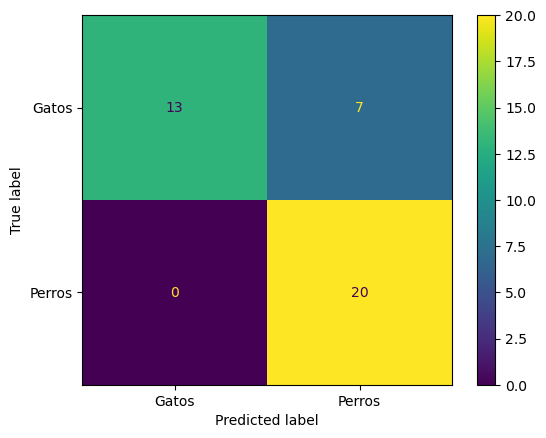

In [11]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import svm

# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'C': [0.01, 0.1, 1, 5], 
    'kernel': ['linear', 'poly', 'sigmoid'],
    # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.5],
    # 'decision_function_shape': ['ovo', 'ovr']
}
    
# Genera el objeto ShuffleSplit para generar un único particionado fijo, con 20% de datos de validación y 
# random_state = 0
ss = ShuffleSplit(n_splits=1,test_size=0.2,random_state=0)

# Haz la llamada a la función GridSearchCV con un clasificador SVC y el diccionario de parámetros definido
# Para acelerar algo el entrenamiento, emplea también el parámetro n_jobs=-1, que hará que se aproveche mejor el
# procesador de tu equipo.
svc = svm.SVC(max_iter=-1)
clasificadores = GridSearchCV(svc,parameter_space,cv=ss,n_jobs=-1)

# Entrena el modelo interno de GridSearchCV, y después obten los mejores valores de C y gamma en C_best y gamma_best
clasificadores = clasificadores.fit(vec_train,y_train.ravel())
mejorClasificador = clasificadores.best_estimator_
print('El mejor clasificador tiene los parámetros: {}'.format(mejorClasificador))

y_true, y_pred = y_test , mejorClasificador.predict(vec_test)
print('El porcentaje de acierto es de un {}%'.format(metrics.accuracy_score(y_true, y_pred)*100))

class_names = ['Gatos', 'Perros']
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
#Miro cuales son las imágenes falladas por la predicción
fallados = []
for i in range(len(X_test)):
    if np.round(y_pred[i]) != y_test[i][0]:
        fallados.append(i)

print('Las imágenes falladas en la predicción son: {}'.format(fallados))

##### Resultados obtenidos con SVM:
Extrac1:
- Versión uniforme ~ 82.5% de accuracy.

Extrac2:
- Versión regularizada ~ 82.5% de accuracy.


## Modelo 6: Ensembles
Hasta ahora, nuestros modelos se han basado en un único clasificador, ¿qué ocurre si en su lugar usamos varios? Esto es a lo que pretenden responder los ensembles. En esta parte, entrenaremos varios modelos distintos de ensemble para tratar de predecir lo mejor posible.

### Ensemble 1: Adaboost con decision stumps
En primer lugar, usaremos un adaboost (o boosting) para encontrar el mejor modelo. Este adaboost lo haremos usando árboles de un solo nodo (decision stumps). Sin embargo, a la hora de realiar el boosting en importante tener en cuenta el número de clasificadores que queremos utilizar. Como siempre, el problema se reduce a que usando pocos no nos ajustamos y si usamos demasiado estaremos sobreentrenando. Para encontrar el número óptimo, iteraremos sobre una cantidad finita de estos, tal y como se muestra en el código de más abajo. Téngase en cuenta que este "número ideal" será distinto para cada una de las extracciones de características que hemos implementado.

Results on the test set:
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92        20
         1.0       0.87      1.00      0.93        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40

Las imágenes falladas en la predicción son: [8, 11, 18]


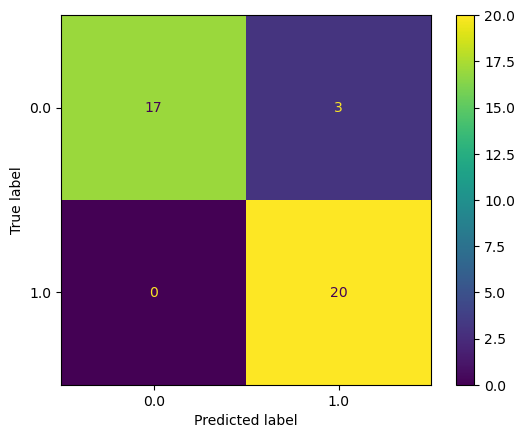

In [12]:
# Adaboos con decision stumps
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'n_estimators': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],
}
# Genera el objeto ShuffleSplit para generar un único particionado fijo, con 20% de datos de validación y 
# random_state = 0
ss = ShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
# Llamada al constructor del clasificador AdaBoost
arbol = DecisionTreeClassifier(criterion='entropy', max_depth=1)
adaboost = AdaBoostClassifier(base_estimator=arbol, random_state=12)
# Haz la llamada a la función GridSearchCV con un clasificador SVC y el diccionario de parámetros definido
# Para acelerar algo el entrenamiento, emplea también el parámetro n_jobs=-1, que hará que se aproveche mejor el
# procesador de tu equipo.
clasificadores = GridSearchCV(adaboost,parameter_space,cv=ss,n_jobs=-1)
# Entrena el modelo interno de GridSearchCV, y después obten los mejores valores de C y gamma en C_best y gamma_best
clasificadores = clasificadores.fit(vec_train,y_train.ravel())
accTrainBest = clasificadores.best_estimator_
# Calculo los resultados sobre el conjunto test
y_true, y_pred = y_test , accTrainBest.predict(vec_test)
print('Results on the test set:')
print(classification_report(y_true, y_pred))
#Muestro la matriz de confusión
class_names = np.unique(y_test)
cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
#Miro cuales son las imágenes falladas por la predicción
fallados = []
for i in range(len(X_test)):
    if np.round(y_pred[i]) != y_test[i][0]:
        fallados.append(i)

print('Las imágenes falladas en la predicción son: {}'.format(fallados))


##### Resultados obtenidos:
Extrac1:
- Versión uniforme ~ 93% de accuracy.

Extrac2:
- Versión regularizada ~ 78% de accuracy.

### Ensemble 2: Bagging con decision stumps
Ahora emplearemos bagging para hacer la predicción. El modelo base vuelve a ser un decision stump. De nuevo, el resultado varía mucho en función de cual sea el numero de clasificadores, así que volveremos a iterar sobre unos cuantos para encontrar el óptimo.

Results on the test set:
              precision    recall  f1-score   support

         0.0       0.69      0.55      0.61        20
         1.0       0.62      0.75      0.68        20

    accuracy                           0.65        40
   macro avg       0.66      0.65      0.65        40
weighted avg       0.66      0.65      0.65        40



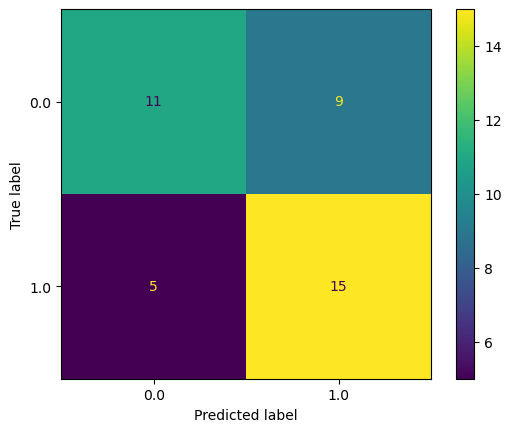

In [13]:
# Adaboos con decision stumps
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
# Genera el diccionario param_grid con los valores indicados
parameter_space = {
    'n_estimators': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],
}
# Genera el objeto ShuffleSplit para generar un único particionado fijo, con 20% de datos de validación y 
# random_state = 0
ss = ShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
# Llamada al constructor del clasificador AdaBoost
arbol = DecisionTreeClassifier(criterion='entropy', max_depth=1)
bagging = BaggingClassifier(arbol, random_state=12)
# Haz la llamada a la función GridSearchCV con un clasificador SVC y el diccionario de parámetros definido
# Para acelerar algo el entrenamiento, emplea también el parámetro n_jobs=-1, que hará que se aproveche mejor el
# procesador de tu equipo.
clasificadores = GridSearchCV(bagging,parameter_space,cv=ss,n_jobs=-1)
# Entrena el modelo interno de GridSearchCV, y después obten los mejores valores de C y gamma en C_best y gamma_best
clasificadores = clasificadores.fit(vec_train,y_train.ravel())
accTrainBest = clasificadores.best_estimator_
# Calculo los resultados sobre el conjunto test
y_true, y_pred = y_test , accTrainBest.predict(vec_test)
print('Results on the test set:')
print(classification_report(y_true, y_pred))
#Muestro la matriz de confusión
class_names = np.unique(y_test)
cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()

##### Resultados obtenidos:
Extrac1:
- Versión uniforme ~ 65% de accuracy.

Extrac2:
- Versión regularizada ~ 78%.

### One vs All
Por último, vamos a implementar el modelo de One vs All con un support vector machine como clasificador base. Dada la simpleza de este modelo, vamos a probar a analizarlo sobre todos los modelos de creación de vectores propios de nuevo.

In [14]:
# Se importan las clase para OVA y para SVM
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# Se llama al constructor de OVA utilizando SVM como clasificador base
OVA = OneVsRestClassifier(estimator=SVC())
# Se entrena el modelo OVA
OVA.fit(vec_train,y_train)
# Calculo el porcentaje de acierto
acc = round(100*OVA.score(vec_test,y_test),2)
print('Usando OVA, hemos predicho correctamente el {}% de las imágenes'.format(acc))

Usando OVA, hemos predicho correctamente el 80.0% de las imágenes


##### Resultados obtenidos:
Extrac1:
- Versión estándar ~ 77.5% de accuracy.
- Versión uniforme ~ 80% de accuracy.
- Versión PCA ~ 75% de accuracy (uniforme).

Extrac2:
- Versión estándar ~ 82.5% de accuracy.
- Versión regularizada ~ 80% de accuracy.


## Modelo 7: Kmeans
El último modelo que vamos a implementar es Kmeans. Nuevamente, se trata de un modelo ideal para nuestro problema, pues sabemos que estos deben ser separables en clases y además conocemos previamente el número de clústeres que necesitamos (solamente 2), con lo que nos ahorramos mucho trabajo de optimización.

In [19]:
from sklearn.cluster import KMeans
# Se llama al constructor de kmeans
kmeans = KMeans(n_clusters=2).fit(vec_train)
clases = kmeans.predict(vec_test)
# Calculo el porcentaje de acierto
accuracy = np.sum(clases.reshape(-1,1)==y_test)/y_test.size
#Trato sobre el resultado por si he calculado los clústeres inversos
if accuracy < 0.5:
    accuracy = 1-accuracy

print('Utilizando el algoritmo de Kmeans, se ha obtenido un {}% de precisión.'.format(accuracy*100))


Utilizando el algoritmo de Kmeans, se ha obtenido un 57.49999999999999% de precisión.
